<a href="https://colab.research.google.com/github/diegotluz/projects-colab/blob/main/DQN_LunarLander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 3 - Reinforcement Learning

# Deep Q-Network (DQN) no LunarLander-v2

### Prof. Dr. Ahirton Lopes

> Neste exemplo, faremos um laboratório prático de Simple Deep Q-Network (DQN) no ambiente openAI LunarLander-v2. Este é um exercício de codificação originalmente encontrado no Nanodegree Deep Reinforcement Learning da Udacity.

- toc: verdadeiro
- emblemas: verdadeiro
- comentários: verdadeiro
-autor: Chanseok Kang
- categorias: [Python, Reinforcement_Learning, PyTorch, Udacity]
- imagem: imagens/LunarLander-v2.gif

## Rede Q Profunda (DQN)
---
Neste notebook, você implementará um agente DQN com o ambiente LunarLander-v2 do OpenAI Gym.

### Importe os pacotes necessários

In [11]:
!pip freeze > requirements.txt

In [12]:
!pip install swig
!pip install gym[box2d]

In [13]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

### Instanciar o ambiente e o agente

Inicialize o ambiente.

In [14]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('Número de estados: ', env.observation_space.shape)
print('número de ações: ', env.action_space.n)

Número de estados:  (8,)
número de ações:  4


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


### Definir arquitetura de rede neural.

Como o ambiente `LunarLander-v2` é uma espécie de ambiente simples, não precisamos de arquitetura complicada. Precisamos apenas de um aproximador de função não linear que mapeie do estado para a ação.

In [15]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed) #criando a especificação do que vai ser a nossa rede neural
        self.fc1 = nn.Linear(state_size, 64) # tranformações lineares vai receber o state_size e o action_size
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size) # vai receber o action_size

    # construindo a rede que vai mapear valores de estado --> valores de ação
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

### Definindo alguns hiperparâmetros

In [16]:
BUFFER_SIZE = int(1e5)  # replay buffer size Tamanho do buzzer de memória/ Replay
BATCH_SIZE = 64         # minibatch size / numero de frames que vai estár passando/ o ideal é usar 32 ou 64
GAMMA = 0.99            # discount factor / Fator de desconto
TAU = 1e-3              # for soft update of target parameters / é uma medida artronomica ultilizada para entender a medida da distancia de um objeto no espaço
LR = 5e-4               # learning rate / taxa de aprendizado
UPDATE_EVERY = 4        # how often to update the network/ frequencia de update

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Definindo o Agente

In [18]:
#definição do Agente

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY # a cada novo incremento de tempo no casp time step (t_step)
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    # acões para cada politica do nosso agente
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        #podemos ter varios comportamentos nessas redes pode-se configurar recompensas maiores ou menores / pode-se usar a politica "gulosa"

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    # aqui começamos sobre a aprendizagem
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)

        # Verificação das perdas
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Definindo o Replay Buffer

In [19]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Treinamento

In [20]:
def dqn(n_episodes=500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: -164.29
Episode 200	Average Score: -113.19
Episode 300	Average Score: -49.61
Episode 400	Average Score: -16.79
Episode 500	Average Score: 129.39


### Plotando o Progresso de Aprendizagem

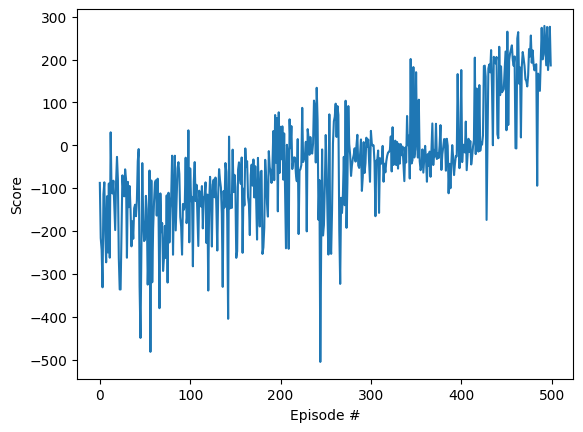

In [22]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

A partir do gráfico acima, observamos que, embora a recompensa máxima seja alcançada rapidamente. Conseguir uma recompensa episódica de > 200 é bom. Vemos que o agente conseguiu isso em menos de 500 episódios (a velocidade é boa!). No entanto, existem muitas flutuações no desempenho (a estabilidade não é boa!).